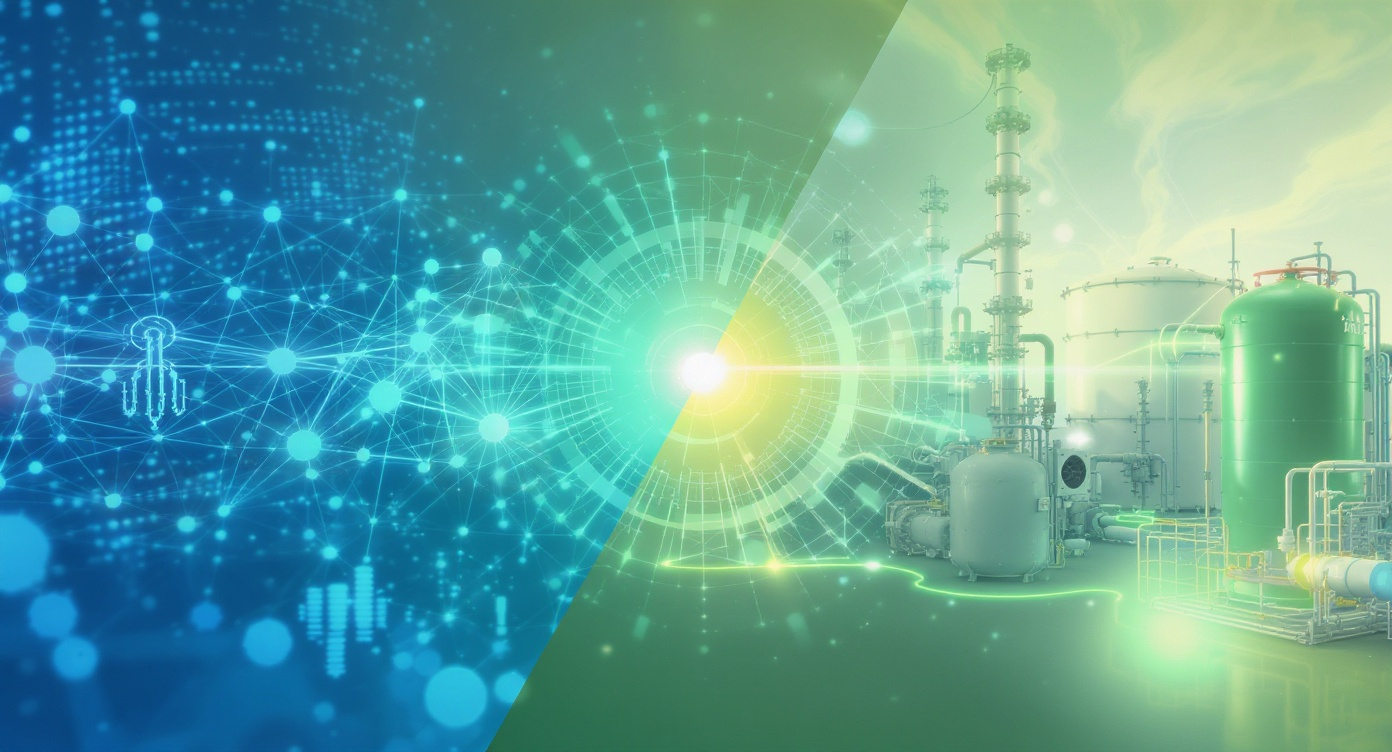

# Simulação e Otimização de Eletrolisador (PEM) com Visualizações Avançadas

Modelo híbrido (físico + IA) que integra equações físico-químicas simplificadas com redes neurais. Ele atende ao cenário atual de pesquisa em hidrogênio verde, no qual há a necessidade de avaliar e otimizar parâmetros operacionais de eletrolisadores (no caso, PEM – Proton Exchange Membrane).

1. Simulação física – Implementa equações de Nernst, perdas de ativação, perdas ôhmicas e perdas de concentração para estimar tensão da célula, eficiência e consumo energético específico.

2. Geração de dados sintéticos – Cria um dataset artificial, mas fisicamente consistente, cobrindo faixas operacionais típicas de PEM.

3. Treino de rede neural (surrogate) – Uma MLP em PyTorch aprende a reproduzir a saída do modelo físico, acelerando predições.

4. Validação do surrogate – Mede erros relativos entre valores simulados e preditos, garantindo precisão (com visualizações gráficas).

5. Otimização multiobjetivo – Usa grid search para explorar condições que minimizem o consumo energético (kWh/kg) e tensão, maximizando a eficiência.

6. Visualização – Gera gráficos comparando valores reais vs. preditos e identifica pontos de operação promissores.

## 1. Importando Bibliotecas

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

ModuleNotFoundError: No module named 'pandas'

## 2. Modelo Físico Simplificado da Membrana de Troca de Prótons (PEM)

*   Definição de constantes
*   Definição de Parâmetros Base
*   Função física



In [ ]:
contFaraday_C_Mol = 96485.3
constUnivGases_J_Mol_K = 8.314
massaMolar_H2_kg_Mol = 0.002016

E0 = 1.229 # V a 25 °C, 1 atm
DensCorrDeTroca_A_cmQuad = 1e-6
correnteLimite_A_cm = 2.5
resistEspecArea_ohm_cmQuad = 0.2

def modeloFisico(corrente, temperatura, precaoParcial, umidade):
    TempKelvin = temperatura + 273.15
    tensaoReversivel = E0 + (constUnivGases_J_Mol_K * TempKelvin / (2 * contFaraday_C_Mol)) * np.log(precaoParcial)
    perdaPorAtivacao = (massaMolar_H2_kg_Mol * TempKelvin / (0.5 * contFaraday_C_Mol)) * np.log(corrente / DensCorrDeTroca_A_cmQuad + 1e-9)
    restEspAreaCelula = resistEspecArea_ohm_cmQuad * (1.0 + 0.1 * (100 - umidade) / 100)
    quedaDeTensaoOhmica = corrente * restEspAreaCelula
    perdaPorConcentracao = -(massaMolar_H2_kg_Mol * TempKelvin / (2 * contFaraday_C_Mol)) * np.log(1 - corrente / correnteLimite_A_cm)
    tensaoTotal = tensaoReversivel + perdaPorAtivacao + quedaDeTensaoOhmica + perdaPorConcentracao
    areaAtivaCentQuad = 100
    correnteTotal = corrente * areaAtivaCentQuad
    numMolsH2_segund = correnteTotal / (2* contFaraday_C_Mol)
    massaH2_segund = numMolsH2_segund * massaMolar_H2_kg_Mol
    consumoEspecEnerg = (tensaoTotal * correnteTotal)/(massaH2_segund * 1000)
    eficiencia = (E0  / tensaoTotal) * 100
    return tensaoTotal, eficiencia, massaH2_segund, consumoEspecEnerg

---
## 3. Geração de dataset sintético (DOE), estatisticas e histogramas

Seguindo a lógica de Modelagem Supervisionada, duas bases de dados (chamadas de Data Frame) serão criadas, de nome "inputs_df" e "outputs_df".
1.   inputs_df: Representam as condições de operação impostas ao eletrolisador, ou seja, as variáveis experimentais escolhidas (features X).
  * Corrente (A/cm²)
  * Temperatura (°C)
  * Pressão (bar)
  * Umidade (%)
2.   outputs_df: Representam o comportamento resultante do eletrolisador sob aquelas condições, portanto são variáveis provenientes de cálculo e observação.
  * Tensão da célula (V)
  * Eficiência (%)
  * Consumo específico de energia (kWh/kg H₂)
---

In [ ]:
np.random.seed(42)
numeroDeAmostras = 10000

correnteVetorValores = np.random.uniform(0.5, 2.0, numeroDeAmostras)
temperaturaVetorValores = np.random.uniform(50, 80, numeroDeAmostras)
pressaoVetorValores = np.random.uniform(1, 30, numeroDeAmostras)
umidadeVetorValores = np.random.uniform(80, 100, numeroDeAmostras)

X, Y = [], []
for i, temperatura, pressaoPacial, umidade in zip(correnteVetorValores, temperaturaVetorValores, pressaoVetorValores, umidadeVetorValores):
    tensaoTotal, eficiencia, massaH2_segund, consumoEspecEnerg = modeloFisico(i, temperatura, pressaoPacial, umidade)
    X.append([i, temperatura, pressaoPacial, umidade])
    Y.append([tensaoTotal, eficiencia, consumoEspecEnerg])

X = np.array(X)
Y = np.array(Y)

inputs_df = pd.DataFrame(X, columns=["Corrente (A/cm²)", "Temperatura (°C)", "Pressão (bar)", "Umidade (%)"])
outputs_df = pd.DataFrame(Y, columns=["Tensão (V)", "Eficiência (%)", "Consumo Específico de Energia (kWh/kg)"])


print("Resumo das variáveis de entrada:")
display(inputs_df.describe())
print(75 * '-')
print("Resumo das saídas simuladas:")
display(outputs_df.describe())

Resumo das variáveis de entrada:


,Corrente (A/cm²),Temperatura (°C),Pressão (bar),Umidade (%)
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.241239,65.135896,15.501461,89.974268
std,0.431445,8.678837,8.316439,5.779892
min,0.500017,50.004732,1.001396,80.000111
25%,0.869493,57.618374,8.358689,84.937145
50%,1.238793,65.176903,15.559975,90.000605
75%,1.610010,72.694377,22.595542,94.942325
max,1.999577,79.997745,29.997128,99.995787


---------------------------------------------------------------------------
Resumo das saídas simuladas:


,Tensão (V),Eficiência (%),Consumo Específico de Energia (kWh/kg)
count,10000.000000,10000.000000,10000.000000
mean,1.516687,81.304650,145176.613249
std,0.087802,4.719263,8404.371912
min,1.341262,72.932523,128384.948663
25%,1.441038,77.246098,137935.453071
50%,1.514878,81.128636,145003.447670
75%,1.591019,85.285774,152291.600351
max,1.685119,91.630149,161298.848305


Exibindo as primeiras 5 linhas do Data Frame dos dados de entrada:

In [ ]:
inputs_df.head()

,Corrente (A/cm²),Temperatura (°C),Pressão (bar),Umidade (%)
0,1.061810,61.209225,22.169951,92.762891
1,1.926071,59.987363,6.350848,89.185849
2,1.597991,55.284617,11.052551,99.289970
3,1.397988,68.218000,20.235138,84.379569
4,0.734028,64.298725,14.980591,91.757128


Exibindo as primeiras 5 linhas do Data Frame dos dados de saída:

In [ ]:
outputs_df.head()

,Tensão (V),Eficiência (%),Consumo Específico de Energia (kWh/kg)
0,1.487734,82.608854,142405.218747
1,1.645119,74.705824,157470.077734
2,1.583023,77.636260,151526.258330
3,1.557402,78.913488,149073.779002
4,1.416560,86.759463,135592.494076


In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=inputs_df["Corrente (A/cm²)"], y=outputs_df["Tensão (V)"], alpha=0.7)
plt.title("Corrente vs. Tensão da célula")
plt.xlabel("Corrente (A/cm²)")
plt.ylabel("Tensão da célula (V)")
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

Sobre o gráfico de dispersão acima, a relação é linear crescente → conforme a corrente aumenta, a tensão também sobe.

Isso é esperado fisicamente: em eletrolisadores, tensões maiores são necessárias para sustentar densidades de corrente mais altas, devido às perdas ôhmicas e de ativação.

A leve dispersão em torno da linha se deve a outros fatores de entrada (temperatura, pressão, umidade) que também influenciam a resposta.

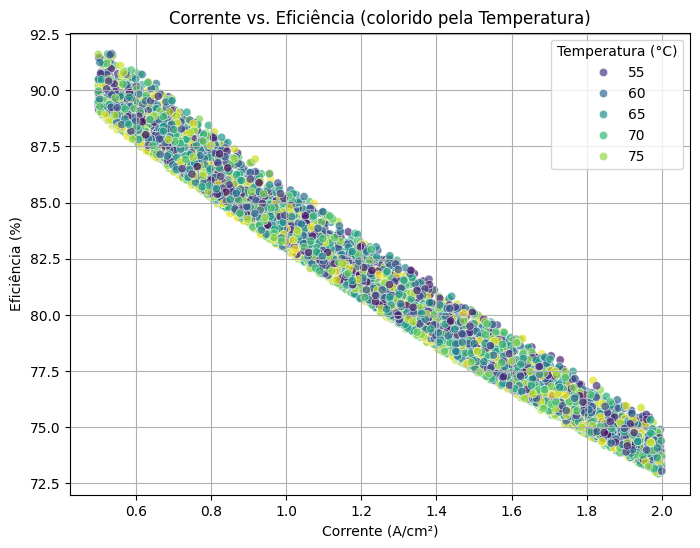

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=inputs_df["Corrente (A/cm²)"], y=outputs_df["Eficiência (%)"], hue=inputs_df["Temperatura (°C)"], palette="viridis", alpha=0.7)
plt.title("Corrente vs. Eficiência (colorido pela Temperatura)")
plt.xlabel("Corrente (A/cm²)")
plt.ylabel("Eficiência (%)")
plt.legend(title="Temperatura (°C)")
plt.grid(True)
plt.show()

Com relação ao gráfico Corrente vs. Eficiência (colorido pela Temperatura), é certo que há:
1. Tendência global:

* Conforme a corrente aumenta, a eficiência diminui de forma quase linear.

* Isso ocorre porque em correntes mais altas, as perdas de ativação, ôhmicas e de concentração crescem, exigindo mais energia elétrica para a mesma quantidade de hidrogênio produzido.

2. Influência da temperatura:

* As cores mostram que, embora a temperatura afete a eficiência, o impacto é secundário em relação à corrente.

* Em temperaturas mais altas (ex.: 75 °C, verde), a eficiência tende a ser ligeiramente maior em comparação com temperaturas mais baixas (ex.: 55 °C, azul).

* Isso faz sentido fisicamente, pois temperaturas elevadas reduzem a resistência ôhmica da membrana e aceleram a cinética eletroquímica, favorecendo o desempenho.

3. Região ótima:

* A faixa de correntes mais baixas (0,5 – 0,8 A/cm²) apresenta eficiências acima de 88–90%, indicando condições mais favoráveis para operação econômica.

* Já em correntes próximas de 2,0 A/cm², a eficiência cai para valores em torno de 73–75%, mostrando um limite prático para evitar desperdício de energia.

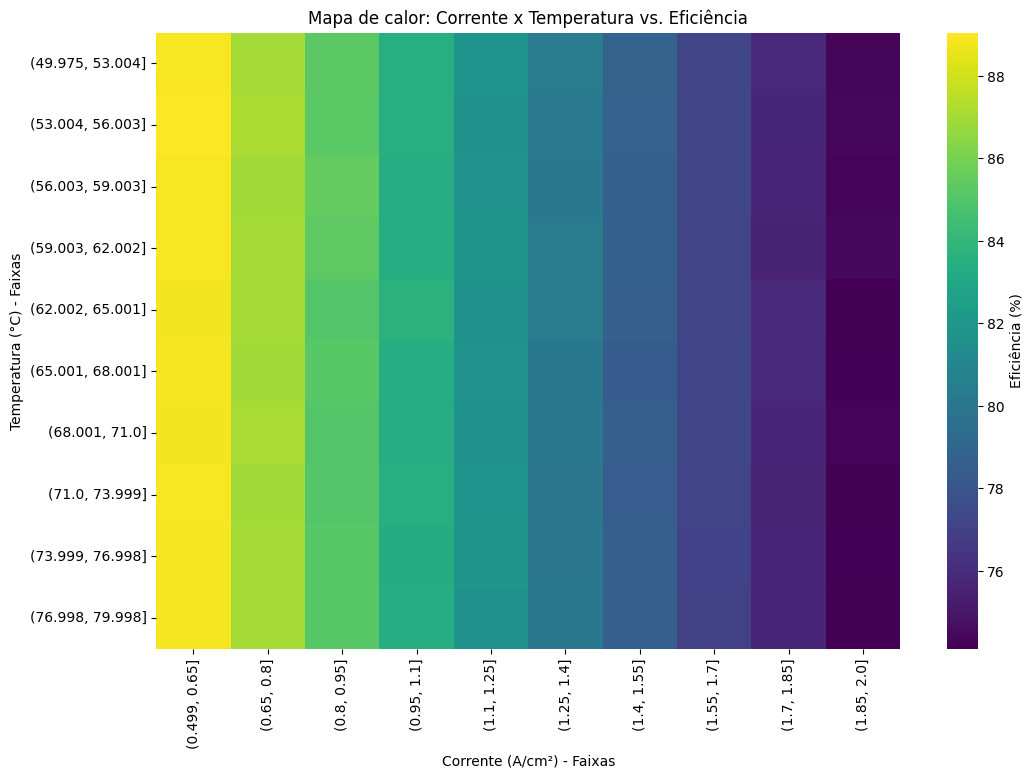

In [ ]:
df_full = pd.concat([inputs_df, outputs_df], axis=1)

df_full["Corrente_bin"] = pd.cut(df_full["Corrente (A/cm²)"], bins=10)
df_full["Temperatura_bin"] = pd.cut(df_full["Temperatura (°C)"], bins=10)

pivot = df_full.pivot_table(values="Eficiência (%)",
                            index="Temperatura_bin",
                            columns="Corrente_bin",
                            aggfunc="mean",
                            observed=False)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': 'Eficiência (%)'})
plt.title("Mapa de calor: Corrente x Temperatura vs. Eficiência")
plt.xlabel("Corrente (A/cm²) - Faixas")
plt.ylabel("Temperatura (°C) - Faixas")
plt.show()

O mapa de calor Corrente × Temperatura vs. Eficiência resume de forma visual o comportamento do seu eletrolisador:
1. Predomínio da corrente:

* A eficiência cai fortemente conforme a corrente aumenta, indo de valores acima de 88% em baixas correntes para ~74% em correntes próximas a 2 A/cm².

* Isso confirma que a corrente é a variável com maior impacto negativo sobre a eficiência, por conta do aumento das perdas eletroquímicas.

2. Influência da temperatura:

* O eixo da temperatura mostra uma variação sutil: quanto maior a temperatura, ligeiro ganho de eficiência em todas as faixas de corrente.

* Isso se deve à melhora da condutividade iônica da membrana e da cinética eletroquímica em temperaturas mais altas.

3. Zona ótima de operação:

* O canto superior esquerdo do mapa (baixa corrente e temperaturas mais altas) é a região mais favorável, exibindo eficiências acima de 88%.

* O canto inferior direito (alta corrente e baixa temperatura) é a condição menos eficiente, com valores próximos de 74–76%.

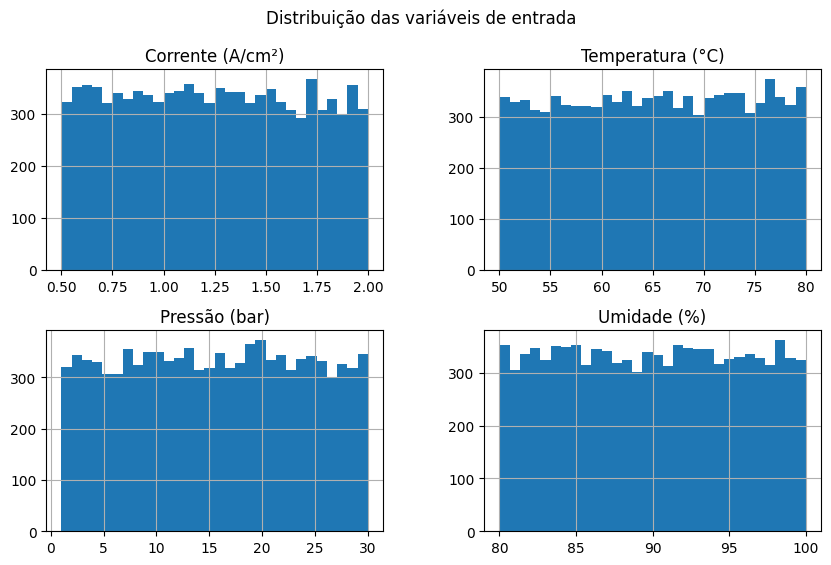

In [ ]:
inputs_df.hist(figsize=(10,6), bins=30)
plt.suptitle("Distribuição das variáveis de entrada")
plt.show()

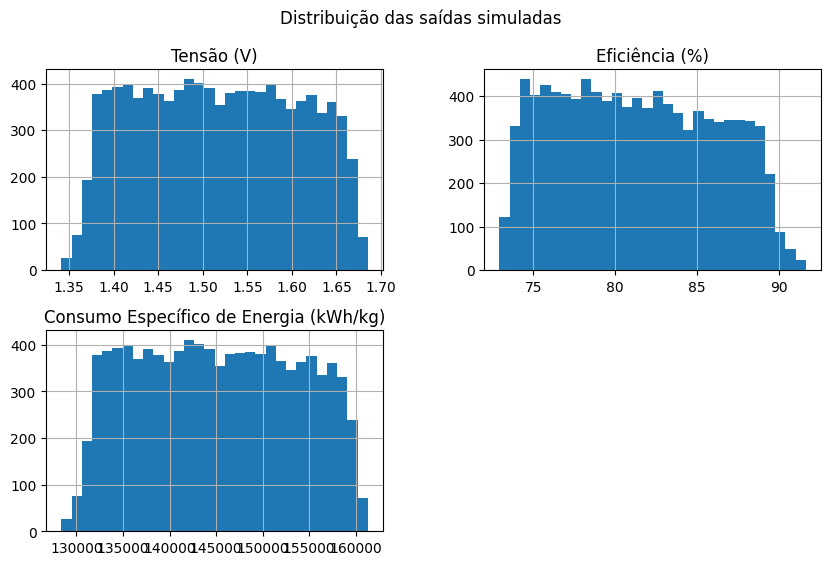

In [ ]:
outputs_df.hist(figsize=(10,6), bins=30)
plt.suptitle("Distribuição das saídas simuladas")
plt.show()

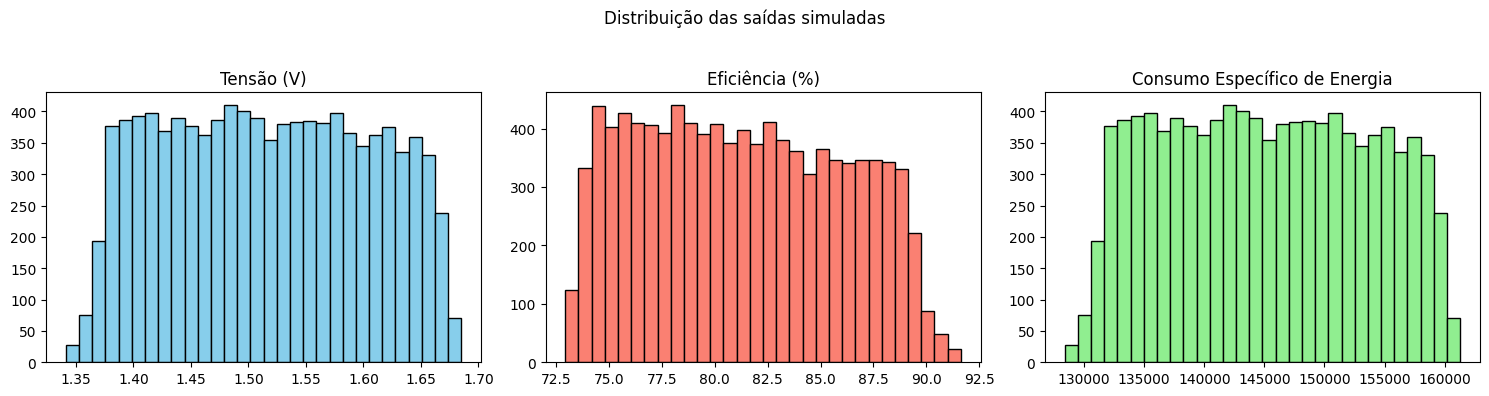

In [ ]:
outputs_df = outputs_df.rename(columns=lambda x: x.replace("Especo", "Específico"))

fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].hist(outputs_df['Tensão (V)'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Tensão (V)')

axes[1].hist(outputs_df['Eficiência (%)'], bins=30, color='salmon', edgecolor='black')
axes[1].set_title('Eficiência (%)')

axes[2].hist(outputs_df['Consumo Específico de Energia (kWh/kg)'], bins=30, color='lightgreen', edgecolor='black')
axes[2].set_title('Consumo Específico de Energia')

plt.suptitle("Distribuição das saídas simuladas")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Acerca do histograma acima, as distribuições das variáveis revelam que:
* Tensão (V) e Consumo Específico de Energia: A distribuição dessas duas variáveis é notavelmente uniforme e ampla, cobrindo faixas de valores significativas (1.45V a 1.65V para a tensão e 135.000 a 160.000 kWh/kg para o consumo). Isso indica que a simulação explorou de maneira eficaz uma grande variedade de condições operacionais, gerando dados de forma homogênea para essas duas saídas do modelo.

* Eficiência (%): A distribuição da eficiência é menos uniforme e tem um pico mais definido entre 75% e 82.5%. A maior parte das simulações resultou em eficiências dentro dessa faixa, com uma queda mais rápida na frequência de valores acima de 85%. Isso sugere que o modelo físico tende a operar predominantemente nesse intervalo de eficiência, sendo mais difícil alcançar valores muito altos.

* Conclusão Geral: Os gráficos confirmam que a simulação criou um conjunto de dados sintéticos robusto e bem distribuído para as variáveis de tensão e consumo de energia, enquanto a distribuição da eficiência reflete o comportamento intrínseco do modelo físico subjacente, que tem uma concentração maior de resultados em uma faixa específica.

- Pré-processamento dos dados: Normalizando, treinando e testando variáveis de entrada e saída antes de aplicá-los a rede neural:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
scaler_X = StandardScaler().fit(X_train)
scaler_Y = StandardScaler().fit(Y_train)
X_train = torch.tensor(scaler_X.transform(X_train), dtype=torch.float32)
Y_train = torch.tensor(scaler_Y.transform(Y_train), dtype=torch.float32)
X_test = torch.tensor(scaler_X.transform(X_test), dtype=torch.float32)
Y_test = torch.tensor(scaler_Y.transform(Y_test), dtype=torch.float32)

## 4. Rede Neural (Surrogate)

In [ ]:
class ModeloSurrogateMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 3)
        )
    def forward(self, x):
        return self.layers(x)


modelo = ModeloSurrogateMLP()
criterio = nn.MSELoss()
otimizadorAdam = optim.Adam(modelo.parameters(), lr=0.001)


numeroEpocas = 100
for epocaAtual in range(numeroEpocas):
    modelo.train()
    otimizadorAdam.zero_grad()
    predicoes = modelo(X_train)
    loss = criterio(predicoes, Y_train)
    loss.backward()
    otimizadorAdam.step()
    if (epocaAtual+1)%10==0:
        print(f"Época {epocaAtual+1}/{numeroEpocas}, Perda: {loss.item():.4f}")

Época 10/100, Perda: 0.6719
Época 20/100, Perda: 0.0710
Época 30/100, Perda: 0.0433
Época 40/100, Perda: 0.0228
Época 50/100, Perda: 0.0096
Época 60/100, Perda: 0.0044
Época 70/100, Perda: 0.0025
Época 80/100, Perda: 0.0017
Época 90/100, Perda: 0.0013
Época 100/100, Perda: 0.0011


## 5. Validação do modelo com métricas de avaliação

In [ ]:
modelo.eval()
with torch.no_grad():
    pred = modelo(X_test)


Y_test_denorm = scaler_Y.inverse_transform(Y_test.numpy())
pred_denorm = scaler_Y.inverse_transform(pred.numpy())


mape = np.mean(np.abs((Y_test_denorm - pred_denorm)/Y_test_denorm), axis=0)
print("Erro relativo médio (%): V={:.2f}, Eff={:.2f}, SEC={:.2f}".format(*mape*100))

comparacaoTabular = pd.DataFrame({
"Média real": Y_test_denorm.mean(axis=0),
"Média predita": pred_denorm.mean(axis=0),
"Erro %": 100*np.mean(np.abs((Y_test_denorm - pred_denorm)/Y_test_denorm), axis=0)
}, index=["Tensão (V)", "Eficiência (%)", "CES (kWh/kg)"])
display(comparacaoTabular)

Erro relativo médio (%): V=0.15, Eff=0.15, SEC=0.13


,Média real,Média predita,Erro %
Tensão (V),1.518068,1.517905,0.146512
Eficiência (%),81.228691,81.245613,0.154168
CES (kWh/kg),145308.796875,145311.468750,0.134374


## 6. Visualizações de desempenho do modelo

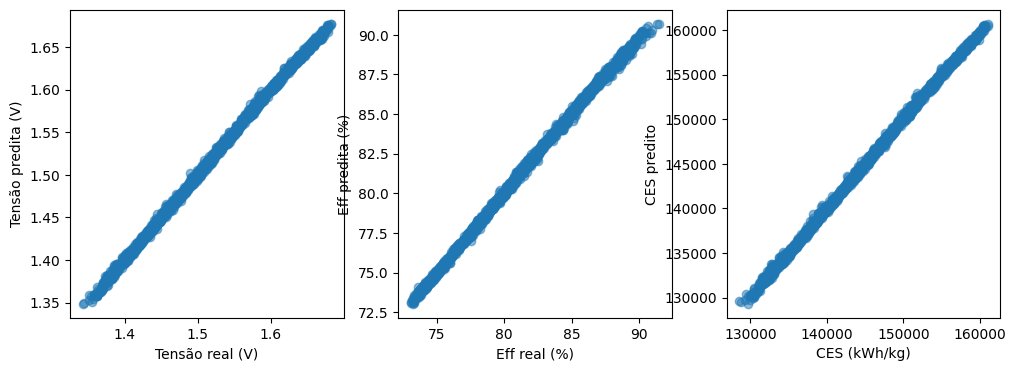

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(Y_test_denorm[:,0], pred_denorm[:,0], alpha=0.5)
plt.xlabel("Tensão real (V)"); plt.ylabel("Tensão predita (V)")


plt.subplot(1,3,2)
plt.scatter(Y_test_denorm[:,1], pred_denorm[:,1], alpha=0.5)
plt.xlabel("Eff real (%)"); plt.ylabel("Eff predita (%)")


plt.subplot(1,3,3)
plt.scatter(Y_test_denorm[:,2], pred_denorm[:,2], alpha=0.5)
plt.xlabel("CES (kWh/kg)"); plt.ylabel("CES predito")
plt.show()

- Curvas tensão x corrente e SEC x corrente em diferentes temperaturas

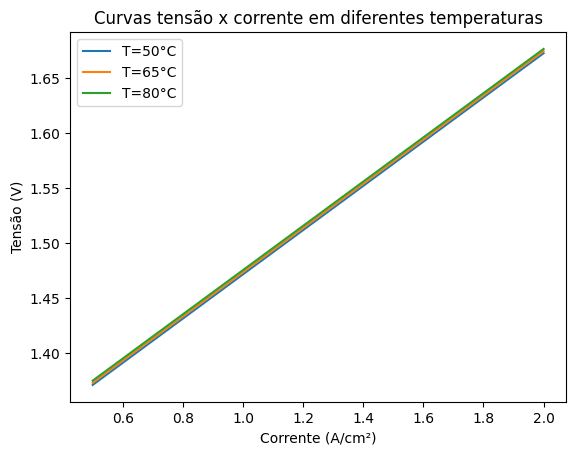

In [ ]:
i_range = np.linspace(0.5, 2.0, 50)
for T in [50, 65, 80]:
    V_vals = [modeloFisico(i, T, 20, 95)[0] for i in i_range]
    plt.plot(i_range, V_vals, label=f"T={T}°C")
plt.xlabel("Corrente (A/cm²)"); plt.ylabel("Tensão (V)")
plt.title("Curvas tensão x corrente em diferentes temperaturas")
plt.legend(); plt.show()

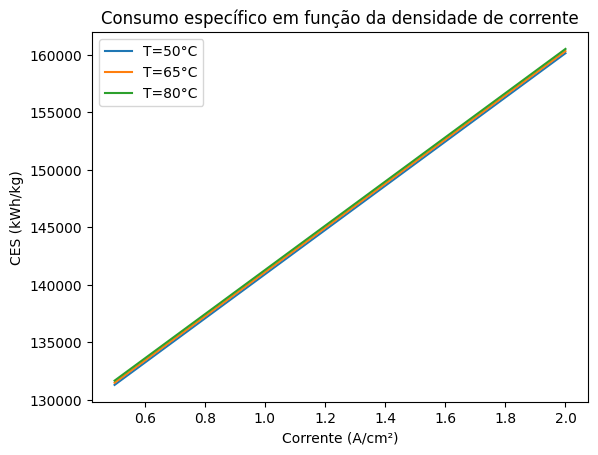

In [ ]:
for T in [50, 65, 80]:
    SEC_vals = [modeloFisico(i, T, 20, 95)[3] for i in i_range]
    plt.plot(i_range, SEC_vals, label=f"T={T}°C")

plt.xlabel("Corrente (A/cm²)")
plt.ylabel("CES (kWh/kg)")
plt.title("Consumo específico em função da densidade de corrente")
plt.legend()
plt.show()